In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
import pickle



sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import print_model_score
from visualization import create_bar_chart


2024-07-31 11:05:49.278613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 11:05:49.345335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 11:05:49.426893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 11:05:49.499347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 11:05:49.522701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 11:05:49.649540: I tensorflow/core/platform/cpu_feature_gu

In [2]:
data=pd.read_csv("../data/processed/data_features_selected.csv")


## Logistic regression

#### Split data

In [3]:

X = data.drop('AR', axis = 1)
y = data['AR']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify = y, random_state=2022)

sampling_strategy = 0.6  # Increase minority class to 60% of the majority class
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=2022)
X_train, y_train = smote.fit_resample(X_train, y_train)


#### Train Model

In [4]:

param_distributions = {
    
        'classifier__C': [0.1, 1, 10, 100,200],
        'classifier__penalty': ['l2'],
        'classifier__solver':  ['lbfgs','newton-cg','liblinear','sag','saga']
    
}


log_model = LogisticRegression(class_weight='balanced', max_iter=4000)

log_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', log_model)
])

log_random_search = RandomizedSearchCV(log_pipeline, param_distributions, cv=10, scoring='f1', n_iter=25, random_state=2022)
log_random_search.fit(X_train, y_train)

best_params = log_random_search.best_params_

print(f"Best Parameters: {best_params}")

best_log_model_params = {
    key.replace('classifier__', ''): value
    for key, value in best_params.items()
}
log_model = LogisticRegression(**best_log_model_params,max_iter=4000)

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_train_pred = log_model.predict(X_train)




Best Parameters: {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 0.1}


#### visualization

##### Shap Values

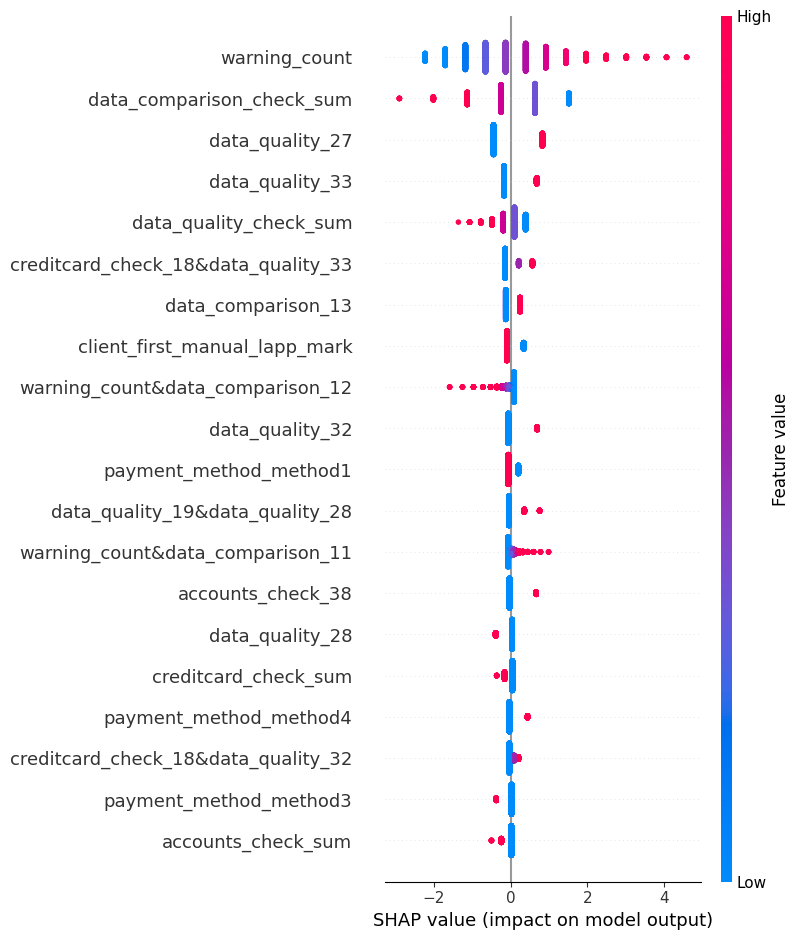

In [5]:
explainer = shap.LinearExplainer(log_model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)


shap.force_plot(
    explainer.expected_value, 
    shap_values[0].values,
    X_test.iloc[0], 
    feature_names=X_test.columns
)
plt.show()


shap.summary_plot(shap_values, X_test)

##### Model Performance

Train Result:
Accuracy Score: 70.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.736750     0.644934  0.709872     0.690842      0.702321
recall        0.833699     0.503479  0.709872     0.668589      0.709872
f1-score      0.782232     0.565495  0.709872     0.673863      0.700959
support    4552.000000  2731.000000  0.709872  7283.000000   7283.000000
_______________________________________________
Confusion Matrix: 
 [[3795  757]
 [1356 1375]]



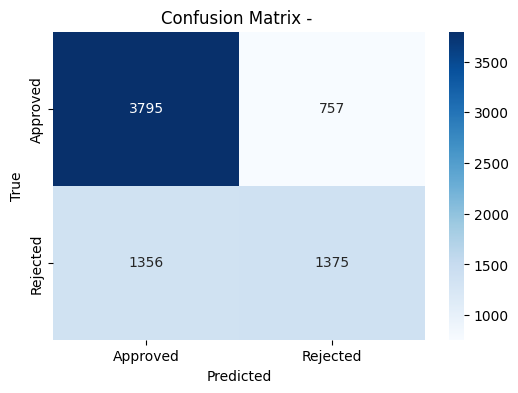

Test Result:
Accuracy Score: 71.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.762553     0.611442  0.719865     0.686997      0.710707
recall        0.832906     0.503435  0.719865     0.668170      0.719865
f1-score      0.796178     0.552207  0.719865     0.674193      0.712472
support    1951.000000  1019.000000  0.719865  2970.000000   2970.000000
_______________________________________________
Confusion Matrix: 
 [[1625  326]
 [ 506  513]]



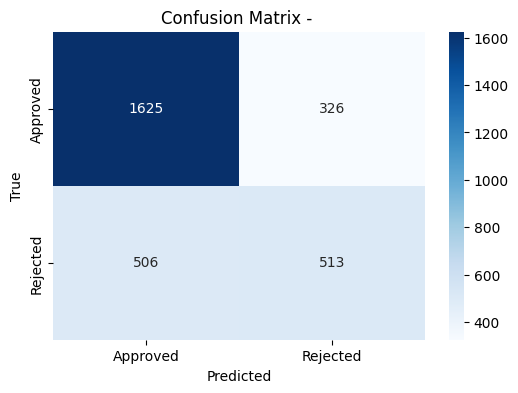

In [6]:
print_model_score(y_train, y_train_pred, train=True)
print_model_score(y_test, y_pred, train=False)

In [7]:
with open('../models/logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(log_model, file)

## XGB Classifier

#### Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify = y, random_state=2022)

sampling_strategy = 0.6  # Increase minority class to 60% of the majority class
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=2022)
X_train, y_train = smote.fit_resample(X_train, y_train)


#### Train Model

In [9]:


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier()

xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                            n_iter=10, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

xgb_random_search.fit(X_train, y_train)

best_params = xgb_random_search.best_params_
best_params['tree_method'] = 'hist'
print(f"Best Parameters: {best_params}")


xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)


y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'tree_method': 'hist'}


#### Visualization

##### Shap Values

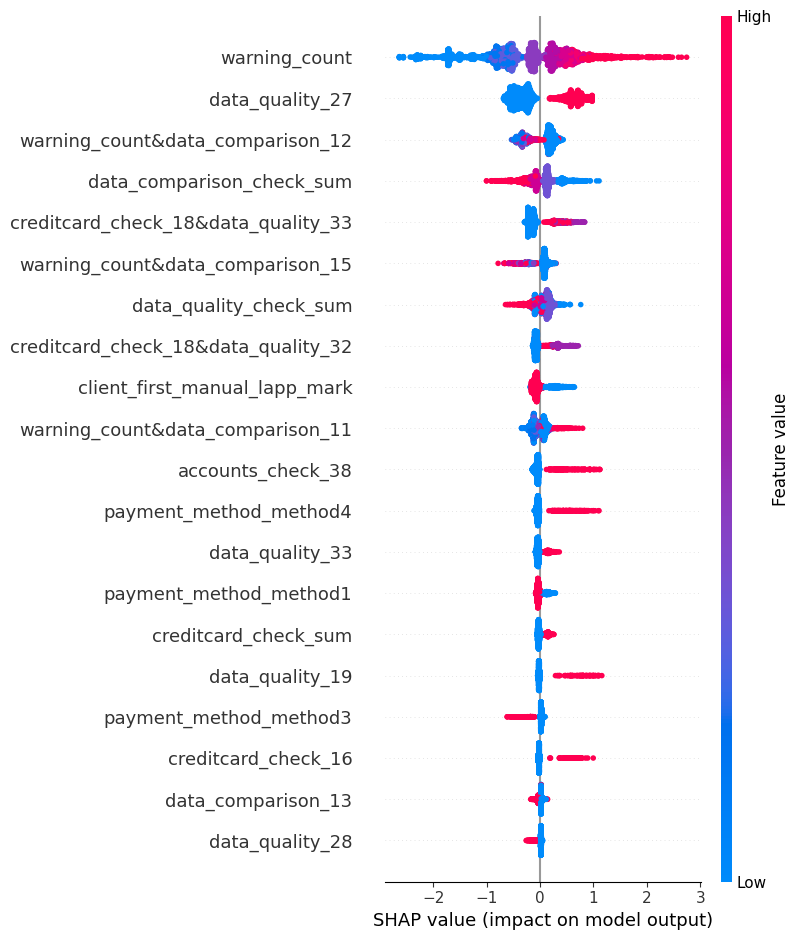

In [10]:

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

plt.show()

##### Model Performance

Train Result:
Accuracy Score: 75.66%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.774225     0.716155  0.756556     0.745190      0.752450
recall        0.861819     0.581106  0.756556     0.721462      0.756556
f1-score      0.815677     0.641601  0.756556     0.728639      0.750402
support    4552.000000  2731.000000  0.756556  7283.000000   7283.000000
_______________________________________________
Confusion Matrix: 
 [[3923  629]
 [1144 1587]]



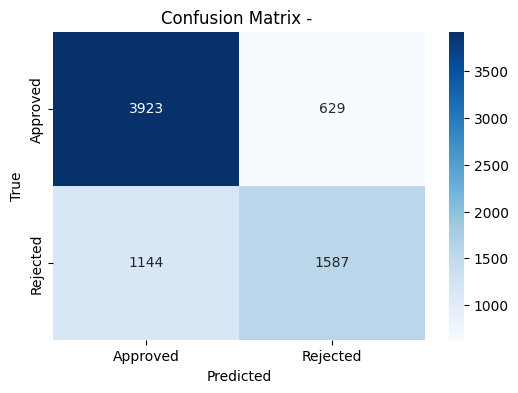

Test Result:
Accuracy Score: 73.40%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.773692     0.634865  0.734007     0.704278      0.726060
recall        0.841107     0.528950  0.734007     0.685029      0.734007
f1-score      0.805992     0.577088  0.734007     0.691540      0.727456
support    1951.000000  1019.000000  0.734007  2970.000000   2970.000000
_______________________________________________
Confusion Matrix: 
 [[1641  310]
 [ 480  539]]



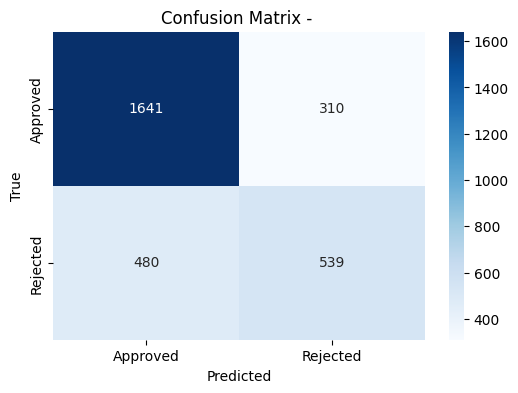

In [11]:
print_model_score(y_train, y_train_pred, train=True)
print_model_score(y_test, y_test_pred, train=False)

In [12]:
with open('../models/xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

## Random Forest

#### Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=2022)
sampling_strategy = 0.6  # Increase minority class to 60% of the majority class
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=2022)
X_train, y_train = smote.fit_resample(X_train, y_train)


#### Train Model

In [14]:

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
}

rf_model = RandomForestClassifier(n_estimators=100)

rf_random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid, cv=StratifiedKFold(10), n_iter=60, 
    scoring='f1', n_jobs=-1, verbose=1, random_state=2022
)

rf_random_search.fit(X_train, y_train)

best_params = rf_random_search.best_params_

print(f"Best Parameters: {best_params}")

rf_model = RandomForestClassifier(**best_params)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 100}


#### Visualization

##### Model Performance

Train Result:
Accuracy Score: 87.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.876707     0.862994  0.872041     0.869851      0.871565
recall        0.925413     0.783082  0.872041     0.854248      0.872041
f1-score      0.900402     0.821099  0.872041     0.860750      0.870665
support    5202.000000  3121.000000  0.872041  8323.000000   8323.000000
_______________________________________________
Confusion Matrix: 
 [[4814  388]
 [ 677 2444]]



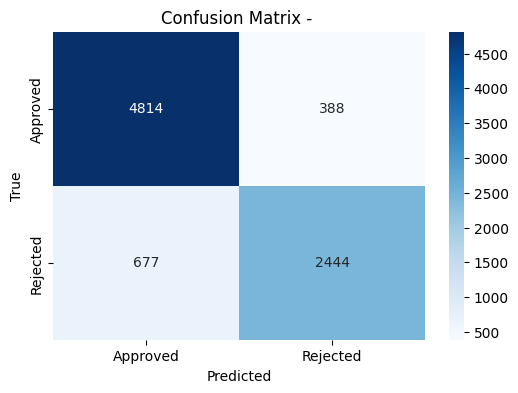

Test Result:
Accuracy Score: 71.72%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.778362    0.591680  0.717172     0.685021      0.714343
recall        0.796311    0.565538  0.717172     0.680924      0.717172
f1-score      0.787234    0.578313  0.717172     0.682774      0.715589
support    1301.000000  679.000000  0.717172  1980.000000   1980.000000
_______________________________________________
Confusion Matrix: 
 [[1036  265]
 [ 295  384]]



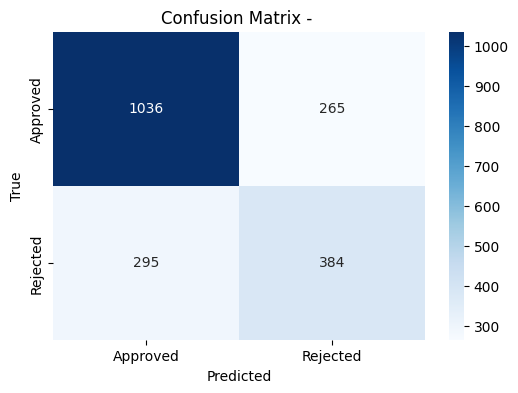

In [15]:
print_model_score(y_train, y_train_pred, train=True)
print_model_score(y_test, y_test_pred, train=False)

In [16]:
with open('../models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

## Ensemble

#### Train Model

In [17]:


# Define the best hyperparameters for pre-trained models
best_log_reg = log_model
best_xgb = xgb_model
best_rf = rf_model

ensemble_model = VotingClassifier(
    estimators=[
        ('log_reg', best_log_reg),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    voting='soft' 
)

ensemble_model.fit(X_train, y_train)

y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)




#### Visualization

##### Model Performance

Train Result:
Accuracy Score: 80.16%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.807021     0.789370  0.801634     0.798195      0.800402
recall        0.897155     0.642422  0.801634     0.769789      0.801634
f1-score      0.849704     0.708355  0.801634     0.779030      0.796700
support    5202.000000  3121.000000  0.801634  8323.000000   8323.000000
_______________________________________________
Confusion Matrix: 
 [[4667  535]
 [1116 2005]]



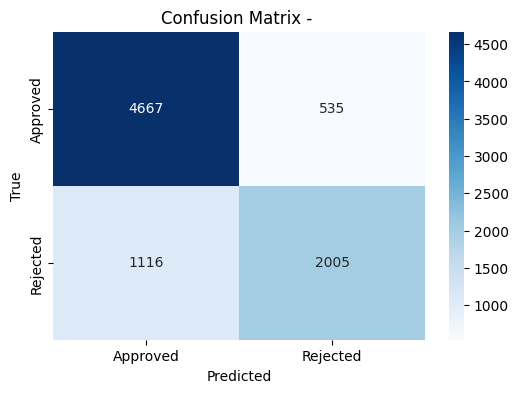

Test Result:
Accuracy Score: 73.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.778571    0.636207  0.736869     0.707389      0.729750
recall        0.837817    0.543446  0.736869     0.690632      0.736869
f1-score      0.807108    0.586180  0.736869     0.696644      0.731345
support    1301.000000  679.000000  0.736869  1980.000000   1980.000000
_______________________________________________
Confusion Matrix: 
 [[1090  211]
 [ 310  369]]



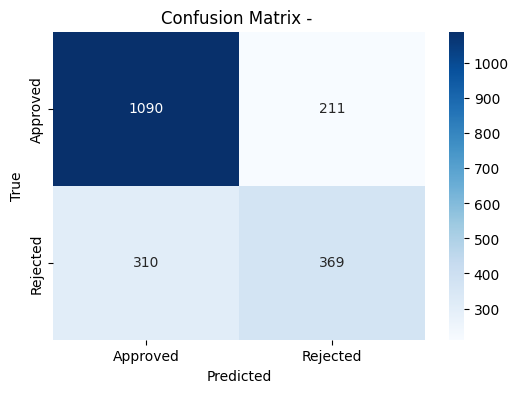

In [18]:
# Print model performance
print_model_score(y_train, y_train_pred, train=True)
print_model_score(y_test, y_test_pred, train=False)

In [19]:
with open('../models/ensemble_model.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)

## All Model Performance

#### ROC AUC of Models

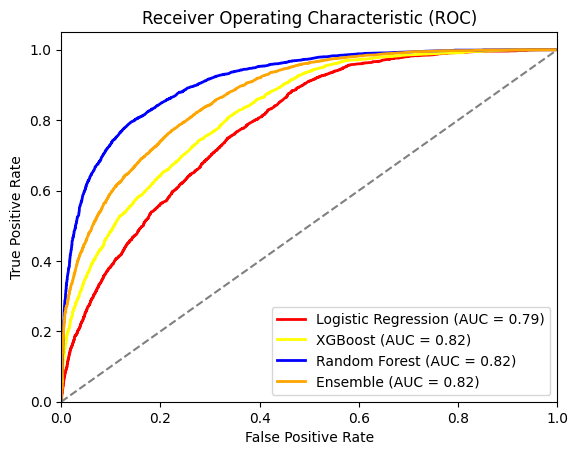

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_proba_logistic = log_model.predict_proba(X)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X)[:, 1]
y_pred_proba_ensemble = ensemble_model.predict_proba(X)[:, 1]

# Calculate ROC curves
fpr_logistic, tpr_logistic, _ = roc_curve(y, y_pred_proba_logistic)
fpr_xgb, tpr_xgb, _ = roc_curve(y, y_pred_proba_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_proba_rf)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y, y_pred_proba_ensemble)

# Calculate AUC
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plot ROC curve
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='yellow', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_ensemble, tpr_ensemble, color='orange', lw=2, label=f'Ensemble (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig("../reports/figures/roc.png")
plt.show()




#### F1-score,accuracy,recall,precision

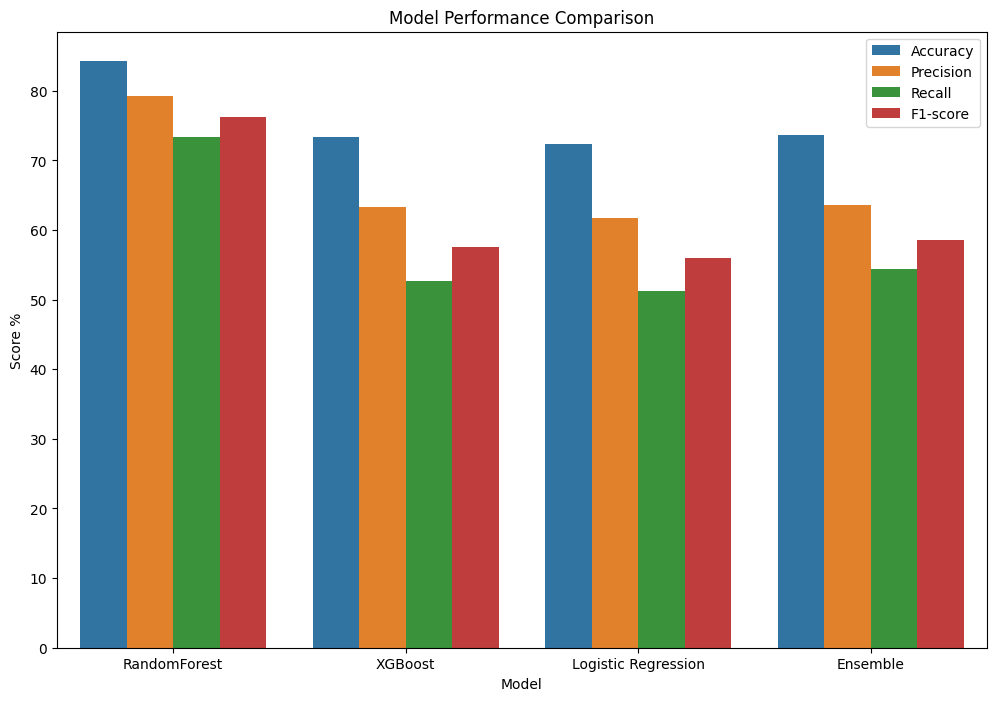

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict and calculate metrics for each model
# RandomForest
rf_y_test_pred = rf_model.predict(X)
rf_metrics = {
    "Model": "RandomForest",
    "Accuracy": accuracy_score(y, rf_y_test_pred)* 100,
    "Precision": precision_score(y, rf_y_test_pred)* 100,
    "Recall": recall_score(y, rf_y_test_pred)* 100,
    "F1-score": f1_score(y, rf_y_test_pred)* 100
}

# XGBoost
xgb_y_test_pred = xgb_model.predict(X_test)
xgb_metrics = {
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, xgb_y_test_pred)* 100,
    "Precision": precision_score(y_test, xgb_y_test_pred)* 100,
    "Recall": recall_score(y_test, xgb_y_test_pred)* 100,
    "F1-score": f1_score(y_test, xgb_y_test_pred)* 100
}

# Logistic Regression
log_y_test_pred = log_model.predict(X_test)
log_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, log_y_test_pred)* 100,
    "Precision": precision_score(y_test, log_y_test_pred)* 100,
    "Recall": recall_score(y_test, log_y_test_pred)* 100,
    "F1-score": f1_score(y_test, log_y_test_pred)* 100
}

# Logistic Regression
ensemble_y_test_pred = ensemble_model.predict(X_test)
ensemble_metrics = {
    "Model": "Ensemble",
    "Accuracy": accuracy_score(y_test, ensemble_y_test_pred)* 100,
    "Precision": precision_score(y_test, ensemble_y_test_pred)* 100,
    "Recall": recall_score(y_test, ensemble_y_test_pred)* 100,
    "F1-score": f1_score(y_test, ensemble_y_test_pred)* 100
}

metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, log_metrics,ensemble_metrics])

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")


# Create a grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Value", hue="Metric", data=metrics_melted)
plt.title("Model Performance Comparison")
plt.ylabel("Score %")
plt.xlabel("Model")
plt.legend(loc='upper right')
plt.show()

plt.tight_layout()
plt.show()


In [22]:
metrics_df

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest,84.269549,79.230280,73.372607,76.189020
1,XGBoost,73.333333,63.362832,52.724595,57.556270
2,Logistic Regression,72.373737,61.702128,51.251841,55.993564
3,Ensemble,73.686869,63.620690,54.344624,58.617951


#### Precision-Recall curves

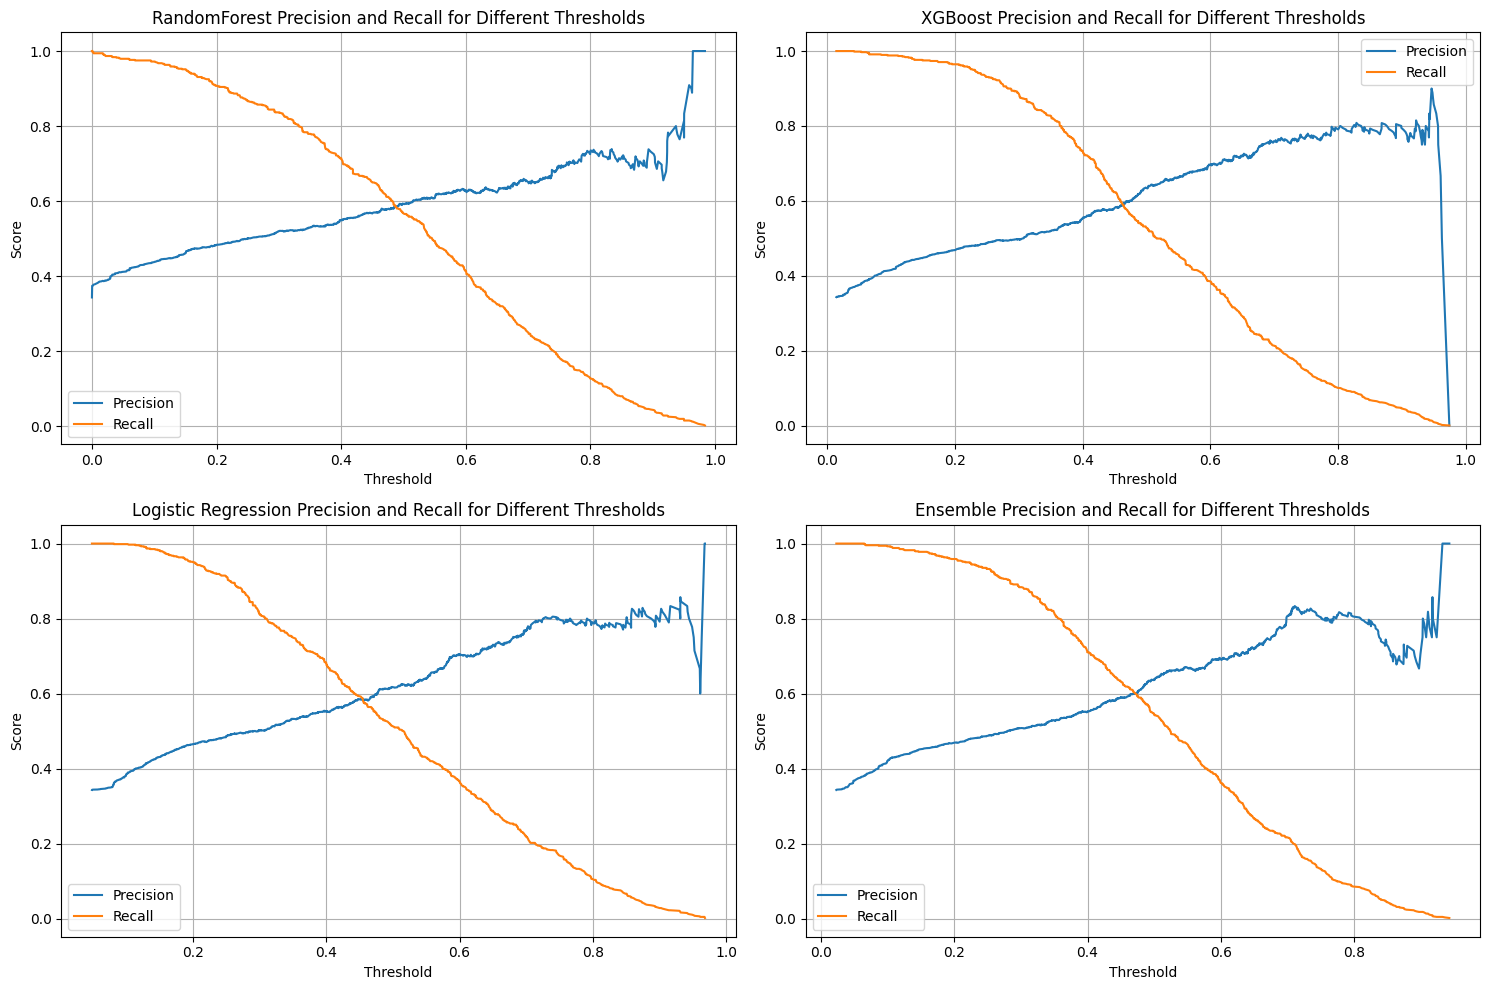

In [23]:
models = [
    ('RandomForest', rf_model),
    ('XGBoost', xgb_model),
    ('Logistic Regression', log_model),
    ('Ensemble', ensemble_model)
]




fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models):
    y_prob = model.predict_proba(X_test)[:, 1] 
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    ax.plot(thresholds, precision[:-1], label=f"Precision")
    ax.plot(thresholds, recall[:-1], label=f"Recall")
    
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title(f"{name} Precision and Recall for Different Thresholds")
    ax.legend(loc="best")
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



#### Threshold Optimization and Model Performance Evaluation on Full Dataset

In [24]:

def model_threshold_calculation(model,model_name,thresholds,X,y):

    # Define costs
    false_negative_cost = 17
    false_positive_cost = 14

    costs = []
    fn_costs = []
    fn_count = []
    fp_costs = []
    fp_count = []
    auto_reject = []
    auto_approve = []
    confusion_matrices = []
    y_prob = model.predict_proba(X)[:, 1]
    cost_df=pd.DataFrame()

    
    for threshold in thresholds:
        # Apply the threshold to classify
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate the confusion matrix
        cm = confusion_matrix(y, y_pred)
        
        # Extract confusion matrix components
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate costs
        fn_cost = fn * false_negative_cost
        fp_cost = fp * false_positive_cost
        total_cost = fn_cost + fp_cost
        
        # Store results
        costs.append(total_cost)
        fn_costs.append(fn_cost)
        fp_costs.append(fp_cost)
        fp_count.append(fp)
        fn_count.append(fn)
        auto_approve.append(np.sum(y_prob < threshold))
        auto_reject.append(np.sum(y_prob >= threshold))
        confusion_matrices.append(cm)


        threshold_df = pd.DataFrame({
            'Model Name':model_name,
            'Threshold': threshold,
            'Cost': costs,
            'False Negative Count': fn_count,
            'False Negative Cost': fn_costs,
            'False Positive Count': fp_count,
            'False Positive Cost': fp_costs,
            'Auto Reject': auto_reject,
            'Auto Approve': auto_approve
        })
        cost_df = pd.concat([cost_df, threshold_df], ignore_index=True)

    cost_df=cost_df.sort_values(by='Cost',ascending=True)
    best_cost_model=cost_df.iloc[0]

    return best_cost_model


In [25]:
best_threshold_per_model = []

# Loop through models and calculate best thresholds
for model_name, model in models:
    best_threshold = model_threshold_calculation(model, model_name,thresholds,X,y)
    best_threshold_per_model.append(best_threshold)

# Convert the list of best thresholds to a DataFrame for better visualization
best_threshold_df = pd.DataFrame(best_threshold_per_model)
best_threshold_df

,Model Name,Threshold,Cost,False Negative Count,False Negative Cost,False Positive Count,False Positive Cost,Auto Reject,Auto Approve
501363,RandomForest,0.562051,24303,877,14909,671,9394,3189,6709
623113,XGBoost,0.624282,38122,1596,27132,785,10990,2584,7314
842575,Logistic Regression,0.750165,43156,1566,26622,1181,16534,3010,6888
629732,Ensemble,0.627532,32283,1213,20621,833,11662,3015,6883
